# MoBike Lyfecycle Prediction

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
import datetime

# Table of Content:
* [0 Load Dataset](#0-Load-Dataset)
* [1 Data Preprocessing](#1-Data-Preprocessing)
  - [1.1 Trim Trip Duration](#1.1-Trim-Trip-Duration)
  - [1.2 Discover Lifecycle Interval](#1.2-Discover-Lifecycle-Interval)
    + [1.2.1 KMeans](#1.2.1-KMeans)
    + [1.2.2 Probability Value](#1.2.2-Probability-Value)
* [2 Data Analysis](#2-Data-Analysis)
  - [2.1 Current Feature Analysis](#2.1-Current-Feature-Analysis)
    + [2.1.1 Lifecycle VS Subscription Ratio](#2.1.1-Lifecycle-VS-Subscription-Ratio)
    + [2.1.2 Lifecycle VS Trips Number](#2.1.2-Lifecycle-VS-Trips-Number)
    + [2.1.3  Station VS Lifecycle](#2.1.3-Station-VS-Lifecycle)
    + [2.1.4 Station VS Crime](#2.1.4-Station-VS-Crime)
    + [2.1.5 Lifecycle VS Period](#2.1.5-Lifecycle-VS-Period)
  - [2.2 Weather](#2.2-Weather)
    + [2.2.1 Lifecycle VS Temperature](#2.2.1-Lifecycle-VS-Temperature)
    + [2.2.2 Lifecycle VS Dew Point](#2.2.2-Lifecycle-VS-Dew-Point)
    + [2.2.3 Lifecycle VS Humidity](#2.2.3-Lifecycle-VS-Humidity)
    + [2.2.4 Lifecycle VS Pressure](#2.2.4-Lifecycle-VS-Pressure)
    + [2.2.5 Lifecycle VS Visibility](#2.2.5-Lifecycle-VS-Visibility)
    + [2.2.6 PCA](#2.2.6-PCA)
  - [2.3 Income and Education](#2.3-Income-and-Education)
  - [2.4 Crime](#2.4-Crime)
  - [2.5 Finalize Dataset](#2.5-Finalize-Dataset)
* [3 Modeling](#3-Modeling)
  - [3.1 Linear Regression](#3.1-Linear-Regression)
    + [3.1.1 Fitting Model](#3.1.1-Fitting-Model)
    + [3.1.2 Error Analysis](#3.1.2-Error-Analysis)
  - [3.2 Decision Tree](#3.2-Decision-Tree)
  - [3.3 Random Forest](#3.3-Random-Forest)
* [4 Conclusion](#4-Conclusion)

# 0 Load Dataset

In [11]:
# Load raw data
trip_bay = pd.read_csv('Dataset/bay_trip_city.csv', index_col=0)
station = pd.read_csv('Dataset/sf-station.csv')
stations_zipcode = pd.read_csv('Dataset/station_postal.csv')
income = pd.read_csv('Dataset/income.csv')
edu = pd.read_csv('Dataset/edu.csv')
station_crime = pd.read_csv('Dataset/stations_crimeScore.csv')
weather = pd.read_csv('Dataset/weather_final.csv', index_col=0)

# Lifecycle dataset is generated by section data preprocessing
lifecycle = pd.read_csv('Dataset/lifecycle_final.csv')

FileNotFoundError: File b'Dataset/bay_trip_city.csv' does not exist

# 1 Data Preprocessing

## 1.1 Trim Trip Duration

In [ ]:
# Check trip duration distribution. We can see that the log data is like normal distribution

# Distribution with raw data
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
labels, values = zip(*Counter(trip_bay.duration).items())
indexes = np.arange(len(labels))
ax1.bar(indexes,values, 1)
plt.xlabel('Raw Duration')
plt.ylabel('Counts')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

## Distribution with log data 
interval_log = np.log10(np.array(trip_bay.duration))
ax2 = plt.subplot(122)
ax2.hist(interval_log, bins=30)
plt.xlabel('Duration(10^)')
plt.ylabel('Counts')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

In [ ]:
# Based on the plots, we use logged data to trim trip duration in order to remove some outliers.
trip_mean = np.mean(interval_log)
trip_std = np.std(interval_log)

# Set up upbound and bottom bound. t1 is about 4 hours and t2 is about 2 mins.
t1 = np.mean(interval_log) + 2*np.std(interval_log)
t2 = np.mean(interval_log) - 2*np.std(interval_log)

# Trim raw trips data by t1 and t2
trip = trip_bay[(trip_bay.duration >= 120) & (trip_bay.duration <= 4*3600) ]

## 1.2 Discover Lifecycle Interval

### 1.2.1 KMeans

In [ ]:
# Since there is no indicator for a bike's lifecycle, we start from using KMeans to group trips of each bike to try to 
# find lifecycle interval. Using Silhouette coefficient to find the optimal K for a specific bike.

def timedifference(row):
    """Calculate time difference between each trip of a specific bike.
    """
    startdifference = ((row['start_date']-initialstart)/np.timedelta64(1, 'h'))
    enddifference   = ((row['end_date']-initialend)/np.timedelta64(1, 'h'))
    return pd.Series((startdifference, enddifference))

def sil_cal_elbow(X, start, end):
    """Calculate silhouette coeff with different k.
    """
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

def generatetraining(choose_id):
    """Generate subset based on bike id.
    """
    global initialstart
    global initialend
    test = trip[trip.bike_id == choose_id]
    test = test.sort_values('start_date')
    test['start_date']=pd.to_datetime(test['start_date'].values)
    test['end_date']=pd.to_datetime(test['end_date'].values)
    initialstart = test.iloc[0].start_date
    initialend   = test.iloc[0].end_date
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    return training_feature

def siloutteplot(training_feature):
    """Plot siloutte vs K.
    """
    t = sil_cal_elbow(training_feature, 2, 10)
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    x_axis=list(range(2,11))
    y_axis=t
    ax.plot(x_axis, t, 'b*-')
    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')
    plt.show()

    
def clusterplot(K, training_feature):
    """Plot clutered trips with optimal K.
    """
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    plt.xlabel('start time')
    plt.ylabel('end time')
    plt.show()

In [ ]:
# KMeans with bike_id 9
training_feature = generatetraining(9)
siloutteplot(training_feature)

In [ ]:
# The optimal K from the above plot is 8. And the clustering for bike id 9 is pretty good
clusterplot(8, training_feature)

In [ ]:
# KMeans with bike_id 342
training_feature = generatetraining(342)
siloutteplot(training_feature)

In [ ]:
# The optimal K from the above plot is 2. And the clustering for bike id 342 is not that good.
clusterplot(2, training_feature)

From the above two exampels, the method is KMenas fails to find the lifecycle interval for all bikes. So we choose the statistical method to get a reasonal lifecycle interval based on the assumption that lifecycle interval is normal distribution.

### 1.2.2 Probability Value

In [ ]:
def collectinterval(dataset):
    """Collect all trip intervals.
    """
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_date'] =pd.to_datetime(temp['start_date'].values)
        temp.loc[:,'end_date'] =pd.to_datetime(temp['end_date'].values)
        temp = temp.sort_values(by=['start_date'])
        for i in range(1, len(temp)):
            t = ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'm')).astype(int)
            interval_list.append(t)
    return interval_list
interval_list = collectinterval(trip)

In [ ]:
# Check the distribution of all intervals
# Distribution with raw data
plt.figure(figsize=(16, 8))
ax3 = plt.subplot(121)
labels, values = zip(*Counter(interval_list).items())
indexes = np.arange(len(labels))
ax3.bar(indexes,values, 1)
plt.xlabel('Raw Interval')
plt.ylabel('Counts')
ax3.set_ylim(0, 1200)
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

## Distribution with log data 
interval_lg = np.log(np.array(interval_list))
interval_lg = interval_lg[~np.isnan(interval_lg)]
interval_lg = interval_lg[~np.isinf(interval_lg)]
ax4 = plt.subplot(122)
ax4.hist(interval_lg, bins=15)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

In [ ]:
# Calculate the up bound of interval. We get t ~= 7 and t2 ~= 4
t = np.mean(interval_lg) + 2*np.std(interval_lg)  # 95%
t2 = np.mean(interval_lg) + (1.644)*np.std(interval_lg) # 90%

In [ ]:
def tempcovert(temp):
    """Group trips with the calculated interval
    """
    final_id_list = []
    bike_group = []
    counts = 0
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            final_id_list.append(final_id)
        else:
            if (((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 4 and
               temp.iloc[i].start_station_id != temp.iloc[i-1].end_station_id):
                counts += 1
            elif ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts))
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    return temp, final_id

def generatelifecycle(dataset):
    """Generate new dataset based on lifecycle.
    """
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_date'])
        temp['start_date'] =pd.to_datetime(temp['start_date'].values)
        temp['end_date'] =pd.to_datetime(temp['end_date'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
    return new_pd, finalid_list

new_pd, finalid_list = generatelifecycle(trip)
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]
new_pd_removelast.to_csv('Dataset/lifecycle_final.csv')

# 2 Data Analysis

## 2.1 Current Feature Analysis

### 2.1.1 Lifecycle VS Subscription Ratio

In [ ]:
station['start_station_id'] = station['id']

# Get the duration for a lifecycle
duration = pd.DataFrame()
a = lifecycle[['bike_group', 'duration']].groupby(['bike_group']).sum()
duration['bike_group'] = a.index
duration['duration'] = a.duration.values

# Get the subscribe_type sum
subscriber = pd.DataFrame()
customer = pd.DataFrame()
b = lifecycle.loc[lifecycle.subscription_type=="Subscriber"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
c = lifecycle.loc[lifecycle.subscription_type=="Customer"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
subscriber['bike_group'] = b.index
subscriber['subscriber'] = b.subscription_type.values
customer['bike_group'] = c.index
customer['customer'] = c.subscription_type.values

# Get the trips count
trips = pd.DataFrame()
d = lifecycle[['bike_group', 'id']].groupby(['bike_group']).count()
trips['bike_group'] = d.index
trips['trips number'] = d.id.values

bdata = pd.merge(duration, subscriber, on="bike_group", how="left")
bdata = pd.merge(bdata, customer, on="bike_group", how="left")
bdata = bdata.fillna(0)
bdata = pd.merge(bdata, trips, on="bike_group", how="left")
bdata['total subscribe types'] = bdata['subscriber'] + bdata['customer']
bdata['subscriber ratio'] = bdata['subscriber']/bdata['total subscribe types']

# Merge geo 
bdata['start_station_id'] = lifecycle['start_station_id']
bdata = pd.merge(bdata, station[['start_station_id', 'lat', 'long']], on='start_station_id', how="left")

In [ ]:
# First plot: Bike LifeCycle V.S. Subscriber Ratio
plt.figure(figsize=(16, 8))
ax5 = plt.subplot(111)
ax5.scatter(bdata['subscriber ratio'], bdata['duration'], color='b', alpha=0.2)
plt.xlabel('Subscriber Ratio')
plt.ylabel('LifeCycle')
plt.title('Bike LifeCycle V.S. Subscriber Ratio')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

### 2.1.2 Lifecycle VS Trips Number

In [ ]:
plt.figure(figsize=(16, 8))
ax6 = plt.subplot(111)
ax6.hist(bdata['trips number'], bins=30, color="green")
plt.xlabel('Trips number')
plt.ylabel('Count')
plt.title('Trips Number Distribution')
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

In [ ]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(bdata['trips number'], bdata['duration'], color='b', alpha=0.2)
plt.xlabel('Trips number in LifeCycle')
plt.ylabel('LifeCycle')
plt.title('Bike LifeCycle V.S. Trips number in LifeCycle')
ax7.set_ylim(0, 550000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

### 2.1.3  Station VS Lifecycle

In [ ]:
# Duration by Stations and Cities

# San Francisco Station Ids and Station Durations
san_francisco_station_ids = lifecycle.loc[lifecycle.city == 'San Francisco'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
san_francisco_station_durations = lifecycle.loc[lifecycle.city == 'San Francisco'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
san_francisco_station_durations = [x[0] for x in san_francisco_station_durations]

# Redwood City Station Ids and Station Durations
redwood_city_station_ids = lifecycle.loc[lifecycle.city == 'Redwood City'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
redwood_city_station_durations = lifecycle.loc[lifecycle.city == 'Redwood City'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
redwood_city_station_durations = [x[0] for x in redwood_city_station_durations]

# Palo Alto Station Ids and Station Durations
palo_alto_station_ids = lifecycle.loc[lifecycle.city == 'Palo Alto'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
palo_alto_station_durations = lifecycle.loc[lifecycle.city == 'Palo Alto'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
palo_alto_station_durations = [x[0] for x in palo_alto_station_durations]

# Mountain View Station Ids and Station Durations
mountain_view_station_ids = lifecycle.loc[lifecycle.city == 'Mountain View'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
mountain_view_station_durations = lifecycle.loc[lifecycle.city == 'Mountain View'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
mountain_view_station_durations = [x[0] for x in mountain_view_station_durations]

# San Jose Station Ids and Station Durations
san_jose_station_ids = lifecycle.loc[lifecycle.city == 'San Jose'][['start_station_id', 'duration']].groupby('start_station_id').sum().index.tolist()
san_jose_station_durations = lifecycle.loc[lifecycle.city == 'San Jose'][['start_station_id', 'duration']].groupby('start_station_id').sum().values.tolist()
san_jose_station_durations = [x[0] for x in san_jose_station_durations]

In [ ]:
# Scatter plot by City. (Reassign station id based on city in order to have some city stations group together in plot.)
plt.figure(figsize=(16, 8))
ax8 = plt.subplot(111)
# Plot 
print("San Francisco Stations Number is: {0}".format(len(san_francisco_station_ids)))
print("Redwood City Stations Number is: {0}".format(len(redwood_city_station_ids)))
print("Palo Alto Stations Number is: {0}".format(len(palo_alto_station_ids)))
print("Mountain View Stations Number is: {0}".format(len(mountain_view_station_ids)))
print("San Jose Stations Number is: {0}".format(len(san_jose_station_ids)))

ax8.scatter(list(range(1, 36)), san_francisco_station_durations, color='blue', label="San Francisco")
ax8.scatter(list(range(36, 43)), redwood_city_station_durations, color='red', label="Redwood City")
ax8.scatter(list(range(43, 48)), palo_alto_station_durations, color='green', label="Palo Alto")
ax8.scatter(list(range(48, 55)), mountain_view_station_durations, color='black', label="Mountain View")
ax8.scatter(list(range(55, 71)), san_jose_station_durations, color='orange', label="San Jose")
plt.xlabel('Station Id Re-grouped by City')
plt.ylabel('LifeCycle Duration')
plt.title('Bike LifeCycle V.S. Stations Based On City')
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)
plt.legend()

In [ ]:
# Heat Map, Check folder 'Html/heatmap.html'
heatMapData = pd.DataFrame()
d = bdata[['duration', 'lat', 'long']].groupby(['lat', 'long']).sum()
lats = []
longs = []
for e in d.index.values.tolist():
    lats.append(e[0])
    longs.append(e[1])
heatMapData['lat'] = lats
heatMapData['long'] = longs
heatMapData['duration'] = d.duration.values

In [ ]:
data = []
for index, row in heatMapData.iterrows():
    temp = {}
    temp['lat'] = row['lat']
    temp['lng'] = row['long']
    temp['count'] = row['duration']
    data.append(temp)

#### 2.1.3.1 Overview
![Overview](images/Duration_Overview.jpeg)

#### 2.1.3.2 San Francisco
![San_Francisco](images/Duration_San_Francisco.jpeg)

#### 2.1.3.3 Redwood City
![Redwood_City](images/Duration_Redwood_City.jpeg)

#### 2.1.3.4 Palo Alto
![Palo_Alto](images/Duration_Palo_Alto.jpeg)

#### 2.1.3.5 Mountain View
![Mountain_View](images/Duration_Mountain_View.jpeg)

#### 2.1.3.6 San Jose
![San_Jose](images/Duration_San_Jose.jpeg)

### 2.1.4 Station VS Crime

In [ ]:
# stations_crimeScore.csv
crime = pd.read_csv('Dataset/stations_crimeScore.csv')
plt.figure(figsize=(16, 8))
ax9 = plt.subplot(111)
crime
ax9.scatter(list(range(1, 36)), crime.loc[crime.city == 'San Francisco']['crime_score'], color='blue', label="San Francisco")
ax9.scatter(list(range(36, 43)), crime.loc[crime.city == 'Redwood City']['crime_score'], color='red', label="Redwood City")
ax9.scatter(list(range(43, 48)), crime.loc[crime.city == 'Palo Alto']['crime_score'], color='green', label="Palo Alto")
ax9.scatter(list(range(48, 55)), crime.loc[crime.city == 'Mountain View']['crime_score'], color='black', label="Mountain View")
ax9.scatter(list(range(55, 71)), crime.loc[crime.city == 'San Jose']['crime_score'], color='orange', label="San Jose")
plt.xlabel('Station Id Re-grouped by City')
plt.ylabel('Crime Score')
plt.title('Crime Score V.S. Stations Based On City')
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
plt.legend()

#### 2.1.4.1 Crime HeatMap Overview
![Overview](images/Crime_Overview.jpeg)

#### 2.1.4.2 San Francisco
![San_Francisco](images/Crime_San_Francisco.jpeg)

#### 2.1.4.3 Redwood City
![Redwood_City](images/Crime_Redwood_City.jpeg)

#### 2.1.4.4 Palo Alto
![Palo_Alto](images/Crime_Palo_Alto.jpeg)

#### 2.1.4.5 Mountain View
![Mountain_View](images/Crime_Mountain_View.jpeg)

#### 2.1.4.6 San Jose
![San_Jose](images/Crime_San_Jose.jpeg)

### 2.1.5 Lifecycle VS Period

In [ ]:
lifecycle['start_date'] = pd.to_datetime(lifecycle['start_date'])
lifecycle['end_date'] = pd.to_datetime(lifecycle['end_date'])

times = list(range(8, 21, 4))
labels = ['morning', 'afternoon', 'evening', 'night']
periods = dict(zip(times, labels))
def period(row):
    visit_start = {'hour': row.start_date.hour, 'min': row.start_date.minute} # get hour, min of visit start
    visit_end = {'hour': row.end_date.hour, 'min': row.end_date.minute} # get hour, min of visit end
    for period_start, label in periods.items():
        period_end = period_start + 4
        if period_start <= visit_start['hour'] < period_end:
            if period_start <= visit_end['hour'] < period_end or (period_end - visit_start['hour']) * 60 - visit_start['min'] > (visit_end['hour'] - period_end) * 60 + visit_end['min']:
                return label
            else:
                return periods[period_end] # assign label of following period  
lifecycle['period'] = lifecycle.apply(period, axis=1)

In [ ]:
period = pd.DataFrame()
d = lifecycle[['bike_group', 'period', 'duration']].groupby(['bike_group', 'period']).sum()
bike_ids = []
p = []
for e in d.index.values:
    bike_ids.append(e[0])
    p.append(e[1])
period['bike_group'] = bike_ids
period['period'] = p
period['duration'] = [x[0] for x in d.values.tolist()]

# Calculate morning duration rate compared to total duration
morning_duration = pd.merge(duration, period.loc[period.period == 'morning'], on='bike_group', how="left")
morning_duration['period'] = morning_duration['period'].fillna('morning')
morning_duration['duration_y'] = morning_duration['duration_y'].fillna(0)
morning_duration['morning rate'] = morning_duration['duration_y']/morning_duration['duration_x']

# Calculate afternoon duration rate compared to total duration
afternoon_duration = pd.merge(duration, period.loc[period.period == 'afternoon'], on='bike_group', how="left")
afternoon_duration['period'] = afternoon_duration['period'].fillna('afternoon')
afternoon_duration['duration_y'] = afternoon_duration['duration_y'].fillna(0)
afternoon_duration['afternoon rate'] = afternoon_duration['duration_y']/afternoon_duration['duration_x']

# Calculate evening duration rate compared to total duration
evening_duration = pd.merge(duration, period.loc[period.period == 'evening'], on='bike_group', how="left")
evening_duration['period'] = evening_duration['period'].fillna('evening')
evening_duration['duration_y'] = evening_duration['duration_y'].fillna(0)
evening_duration['evening rate'] = evening_duration['duration_y']/evening_duration['duration_x']

# Calculate night duration rate compared to total duration
night_duration = pd.merge(duration, period.loc[period.period == 'night'], on='bike_group', how="left")
night_duration['period'] = night_duration['period'].fillna('night')
night_duration['duration_y'] = night_duration['duration_y'].fillna(0)
night_duration['night rate'] = night_duration['duration_y']/night_duration['duration_x']

plt.figure(figsize=(16, 8))
ax10 = plt.subplot(111)
ax10.scatter(morning_duration['morning rate'], morning_duration['duration_x'], color='blue', alpha=1, label="Morning", s=3)
ax10.scatter(afternoon_duration['afternoon rate'], afternoon_duration['duration_x'], color='red', alpha=1, label="Afternoon", s=3)
ax10.scatter(evening_duration['evening rate'], evening_duration['duration_x'], color='green', alpha=1, label="Evening", s=3)
ax10.scatter(night_duration['night rate'], night_duration['duration_x'], color='orange', alpha=1, label="Night", s=3)

plt.xlabel('Period Ratio')
plt.ylabel('LifeCycle Duration')
plt.title('Bike LifeCycle V.S. Period Ratio')
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
plt.legend()

## 2.2 Weather 

In [ ]:
life_weather = lifecycle.merge(weather, on = ['id'])

# multiply the duration and the weather data to see the weather factors that affect a specific trip
life_weather['Tempbysec'] = life_weather['duration'] * life_weather['Temperature']
life_weather['Humibysec'] = life_weather['duration'] * life_weather['Humidity']
life_weather['Dewbysec']  = life_weather['duration'] * life_weather['Dewpoint']
life_weather['Presbysec'] = life_weather['duration'] * life_weather['Pressure']
life_weather['Visibysec'] = life_weather['duration'] * life_weather['Visibility']

t0 = life_weather.groupby('bike_group').sum()
t0['bike_group'] = t0.index
# calculate the weather factors taht affect a specific lifecycle
t0['Tempbyduration'] = t0['Tempbysec'] / t0['duration']
t0['Presbyduration'] = t0['Presbysec'] / t0['duration']
t0['Humibyduration'] = t0['Humibysec'] / t0['duration']
t0['Dewbyduration']  = t0['Dewbysec'] / t0['duration']
t0['Visibyduration'] = t0['Visibysec'] / t0['duration']

lifecycle_weather = t0[['bike_group','duration','Tempbyduration', 'Humibyduration', 'Presbyduration', 'Dewbyduration','Visibyduration']]

### 2.2.1  Lifecycle VS Temperature

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
x_axis=lifecycle_weather.Tempbyduration
y_axis=lifecycle_weather.duration
ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Temprature in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')
plt.show()

### 2.2.2  Lifecycle VS Dew Point

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
x_axis=lifecycle_weather.Dewbyduration
y_axis=lifecycle_weather.duration
ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Dew point in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')
plt.show()

### 2.2.3 Lifecycle VS Humidity

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
x_axis=lifecycle_weather.Humibyduration
y_axis=lifecycle_weather.duration
ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Humidity in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')
plt.show()

### 2.2.4 Lifecycle VS Pressure

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
x_axis=lifecycle_weather.Presbyduration
y_axis=lifecycle_weather.duration
ax.scatter(x_axis, y_axis)
plt.xlabel('Mean Humidity in this lifecycle')
plt.ylabel('Lifecycle in use(sec)')
plt.show()

### 2.2.5 Lifecycle VS Visibility

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
x_axis=lifecycle_weather.Visibyduration
y_axis=lifecycle_weather.duration
ax.scatter(x_axis, y_axis)
plt.xlabel('Mean visibility during trip(meter)')
plt.ylabel('Mean duration in use(sec)')
plt.show()

In general, except Visibility which has a normal distribution shape, other weather factors all have a bimodal shape. It is difficult to find a distinct linear relationship between a weather factor and the lifecycle. All we can determine is that the long lifecycle would not happen when the weather factor is near its minimum value and its maximum value.

### 2.2.6 PCA

Furthermore, we use PCA to combine these four factors except Visibility and reduce the dimensionality to get a “weather index” to represent the weather information.

In [ ]:
# standardize the data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

t = standardize(lifecycle_weather[['Tempbyduration', 'Humibyduration', 'Presbyduration', 'Dewbyduration']])
pca = PCA(n_components=2)
pca.fit(t)
WeatherIndex = pd.DataFrame(pca.fit_transform(t))

To maintain the variance, we decided to reduce the dimensionality to 2, which can maintain 85% variance. Since we have 2 dimensions and 1 target, we generated a 3D plot to explore the relationship as below.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = [16,8], facecolor=[0.9,0.9,0.9])
ax = fig.gca(projection='3d')
data = zip(WeatherIndex[0], WeatherIndex[1], lifecycle_weather.duration)
for x,y,z in data:
    col = ((lifecycle_weather.duration.max()-z)/(lifecycle_weather.duration.max()-lifecycle_weather.duration.min()))
    ax.scatter(x,y,z,c=[(col,0.5,0.5),], marker='o')
ax.set_xlabel('Weather Index - dimension 1')
ax.set_ylabel('Weather Index - dimension 2')
ax.set_zlabel('lifecycle(sec)')
plt.show()

According to the above plot, we could see the long life cycle still remains at the center section of the weather index. But, at the same time, it could not determin whether a short life cycle would happen based on the weather index.

## 2.3 Income and Education

In [ ]:
# Merge income data based on zipcode
lifecycle = lifecycle.drop('zip_code', axis=1)
stations_zipcode.rename(columns={'id':'start_station_id', 'postal':'zip_code'}, inplace=True)
df = pd.merge(lifecycle, stations_zipcode[['start_station_id', 'zip_code']], on='start_station_id', how = 'left')
df = pd.merge(df, income, on='zip_code', how = 'left')

# Merge education data based on zipcode
df = pd.merge(df, edu, on='zip_code', how = 'left')

In [ ]:
# Combine income and edu features with bike lifecycle
gb1 = df[['bike_group', 'duration']].groupby('bike_group').sum()
income_edu = pd.DataFrame()
income_edu['bike_group'] = gb1.index
income_edu['duration'] = gb1.duration.values

cols = ['mean_household_income', 'commuting_to_work_perc_PT', 'mean_work_commuting_time_min', 'perc_HS_or_higher', 'perc_bachelor_or_higher']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
gb2 = df[['bike_group','mean_household_income', 'commuting_to_work_perc_PT', 'mean_work_commuting_time_min', 'perc_HS_or_higher', 'perc_bachelor_or_higher']].groupby('bike_group').mean()

income_edu['mean_household_income'] = gb2.mean_household_income.values
income_edu['commuting_to_work_perc_PT'] = gb2.commuting_to_work_perc_PT.values
income_edu['mean_work_commuting_time_min'] = gb2.mean_work_commuting_time_min.values
income_edu['perc_HS_or_higher'] = gb2.perc_HS_or_higher.values
income_edu['perc_bachelor_or_higher'] = gb2.perc_bachelor_or_higher.values

In [ ]:
fig = plt.figure(figsize=(15, 15))
#Calculate the correlation of every pair of variables in the dataset
ax11 = fig.add_subplot(111)
income_edu_features = income_edu.drop(['bike_group'], axis=1)
mat = ax11.matshow(income_edu_features.corr(method='pearson'), vmin=-1, vmax=1, cmap=plt.cm.RdYlGn)
fig.colorbar(mat,fraction=0.046, pad=0.04)
ax11.set_title('Correlation matrix')
ax11.set_xticks(range(len(income_edu_features.columns)))
ax11.set_xticklabels(income_edu_features.columns)
ax11.set_yticks(range(len(income_edu_features.columns)))
ax11.set_yticklabels(income_edu_features.columns)
ax11.xaxis.set_ticks_position('top')
ax11.yaxis.set_ticks_position('left')
plt.show()

In [ ]:
plt.figure(figsize=(16, 24))
# # Lifecycle vs Mean Household Income
ax12 = plt.subplot(321)
ax12.scatter(income_edu.mean_household_income, income_edu.duration, alpha=0.5)
plt.xlabel('Household Income')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution over Mean Household Income")
ax12.spines['right'].set_color('none')
ax12.spines['top'].set_color('none')


# Lifecycle VS Commuting-to-work Percentage
ax13 = plt.subplot(322)
ax13.scatter(income_edu.commuting_to_work_perc_PT, income_edu.duration, alpha=0.5)
plt.xlabel('Commuting-to-work Percentage (Public Transportation)')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution over Commuting-to-work Percentage")
ax13.spines['right'].set_color('none')
ax13.spines['top'].set_color('none')

# Lifecycle vs Work Commuting Time
ax14 = plt.subplot(323)
ax14.scatter(income_edu.mean_work_commuting_time_min, income_edu.duration, alpha=0.5)
plt.xlabel('Mean Work Commuting Time(in min)')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution over Work Commuting Time")
ax14.spines['right'].set_color('none')
ax14.spines['top'].set_color('none')

# Lifecycle vs Percentage of HighSchool or higher
ax15 = plt.subplot(324)
ax15.scatter(income_edu.perc_HS_or_higher, income_edu.duration, alpha=0.5)
plt.xlabel('Percentage of HighSchool or higher')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution over Percentage of HighSchool or higher")
ax15.spines['right'].set_color('none')
ax15.spines['top'].set_color('none')


# Lifecycle vs Percentage of Percentage of bachelor or higher
ax16 = plt.subplot(325)
ax16.scatter(income_edu.perc_bachelor_or_higher, income_edu.duration, alpha=0.5)
plt.xlabel('Percentage of bachelor or higher')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution over Percentage of bachelor or higher")
ax16.spines['right'].set_color('none')
ax16.spines['top'].set_color('none')

## 2.4 Crime

In [ ]:
# Get start time
start = lifecycle.groupby('bike_group').min()['start_date'].apply(lambda bike_group: datetime.datetime.strptime(bike_group,'%Y-%m-%d %H:%M:%S'))
# Get end time
end = lifecycle.groupby('bike_group').max()['end_date'].apply(lambda bike_group: datetime.datetime.strptime(bike_group,'%Y-%m-%d %H:%M:%S'))
duration_dict = end - start
def get_total_duration(bike_group):
    return duration_dict[bike_group]
lifecycle['total_duration'] = lifecycle.apply(lambda row: get_total_duration(row['bike_group']), axis=1)

In [ ]:
# Replace 'id' with 'station_id'
station_crime.rename(index=str, columns={"id": "start_station_id"}, inplace=True)
crime_dict = pd.DataFrame({'start_station_id': station_crime['start_station_id'],
                  'crime_score': station_crime['crime_score']})
crime_dict = crime_dict.set_index("start_station_id")["crime_score"]

In [ ]:
crime = lifecycle.merge(station_crime[['start_station_id', 'crime_score']], on=['start_station_id'])
crime.rename(index=str, columns={"crime_score": "start_crime_score"}, inplace=True)

In [ ]:
station_crime.rename(index=str, columns={"start_station_id": "end_station_id"}, inplace=True)
crime = crime.merge(station_crime[['end_station_id', 'crime_score']], on=['end_station_id'])
crime.rename(index=str, columns={"crime_score": "end_crime_score"}, inplace=True)

In [ ]:
crime_aggre = crime[['bike_group', 'duration']].groupby('bike_group').sum()
crime_aggre_2 = crime[['bike_group', 'start_crime_score', 'end_crime_score']].groupby('bike_group').mean()
crime_duration = pd.DataFrame()
crime_duration['bike_group'] = crime_aggre.index
crime_duration['duration'] = crime_aggre.duration.values
crime_duration['start_crime_score'] = crime_aggre_2.start_crime_score.values
crime_duration['end_crime_score'] = crime_aggre_2.end_crime_score.values

In [ ]:
plt.figure(figsize=(16, 8))
# Lifecycle vs Mean Crime at Start Station Id
ax17 = plt.subplot(121)
ax17.scatter(crime_duration.start_crime_score, crime_duration.duration, alpha=0.5)
plt.xlabel('Mean Crime Score (Start Station)')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution VS. Mean Crime (Start Station)")
ax17.spines['right'].set_color('none')
ax17.spines['top'].set_color('none')

# Lifecycle vs Mean Crime at End Station Id
ax18 = plt.subplot(122)
ax18.scatter(crime_duration.end_crime_score, crime_duration.duration, alpha=0.5)
plt.xlabel('Mean Crime Score (End Station)')
plt.ylabel('Lifecycle(duration)')
plt.title("Lifecycle Distribution VS. Mean Crime (End Station)")
ax18.spines['right'].set_color('none')
ax18.spines['top'].set_color('none')

## 2.5 Finalize Dataset

In [ ]:
# Merge bdata (trips number, subscriber ration, periods ration) with weather data
final_df = pd.DataFrame()
final_df = lifecycle_weather.merge(bdata[['bike_group','trips number', 'subscriber ratio']], on='bike_group')
final_df = final_df.merge(morning_duration[['bike_group', 'morning rate']], on='bike_group')
final_df = final_df.merge(afternoon_duration[['bike_group', 'afternoon rate']], on='bike_group')
final_df = final_df.merge(evening_duration[['bike_group', 'evening rate']], on='bike_group')
final_df = final_df.merge(night_duration[['bike_group', 'night rate']], on='bike_group')
final_df = final_df.merge(income_edu[['bike_group', 'mean_household_income', 'commuting_to_work_perc_PT',
                                      'mean_work_commuting_time_min', 'perc_HS_or_higher', 'perc_bachelor_or_higher']],
                         on='bike_group')
final_df = final_df.merge(crime_duration[['bike_group', 'start_crime_score', 'end_crime_score']], on='bike_group')

In [ ]:
final_df = final_df.dropna()

In [ ]:
final_df.to_csv('Dataset/final_dataset.csv')

# 3 Modeling

In [15]:
# Loading finalized dataset
life_cycle = pd.read_csv('Dataset/final_dataset.csv')
life_cycle.shape

(3774, 21)

## 3.1 Linear Regression

### 3.1.1 Fitting Model

In [16]:
life_cycle.reset_index(drop=True, inplace=True)
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [17]:
rmse_ratio_train = []
rmse_ratio_test = []
error_ratio_train = []
error_ratio_test = []
row_name = []

# reset index
life_cycle.reset_index(drop=True, inplace=True)

# shuffle and generate index for training/test
np.random.seed(seed=13579)
#train_idx = np.random.choice(range(len(life_cycle)), int(len(life_cycle) * .8), replace=False)
train_idx = np.random.choice(range(len(life_cycle)), 3000, replace=False)
test_idx = list(set(range(len(life_cycle))) - set(list(train_idx)))

# generate training/test
bdata_train = life_cycle.loc[train_idx]
bdata_test = life_cycle.loc[test_idx]
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

# remove unnecessary columns
train_feature = bdata_train.drop(['duration', 'bike_group'], axis=1)
test_feature = bdata_test.drop(['duration', 'bike_group'], axis=1)
train_target = bdata_train['duration']
test_target = bdata_test['duration']
train_feature = standardize(train_feature)
test_feature = standardize(test_feature)

In [18]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

def compute_rmse(predictions, yvalues):
    # compute_rmse
    assert len(predictions) == len(yvalues)
    rmse = np.sqrt(np.sum(np.power(np.subtract(predictions, yvalues),2))/len(yvalues))
    return rmse

def getaccu_lasso(train_feature, train_target):
    # get the validation score for the lasso model
    kf = KFold(10,random_state=2017)
    clf_dict = {}
    valid_accu = []
    for train_index, test_index in kf.split(train_feature):
        X_train, y_train = train_feature.loc[train_index], train_target.loc[train_index].values
        X_test, y_test = train_feature.loc[test_index], train_target.loc[test_index].values
        clf = Lasso()
        clf.fit(X_train, y_train)
        valid_rmse = compute_rmse(clf.predict(X_test),y_test) 
        valid_accu.append(valid_rmse)
        clf_dict[valid_rmse] = clf
    return valid_accu, clf_dict

def caculateratio(clf, feature, target):
    # caculate the error precetange of the deviation of the predicted value to the actual valus
    predict_y = clf.predict(feature)
    compare_predict = pd.concat([target, pd.DataFrame(predict_y)], axis=1)
    compare_predict.columns = ['true', 'predict']
    compare_predict['error_precent'] = (compare_predict.predict - compare_predict.true) / compare_predict.true
    compare_predict['abs_precent'] = np.abs(compare_predict['error_precent'])
    
    return compare_predict

***Optimization - with trips count***

In [19]:
from sklearn.model_selection import GridSearchCV

#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature),test_target))
#grid.best_params_

So the best parameters using all features are:
{'alpha': 18, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [20]:
model = Lasso(alpha=18, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature, train_target)

Lasso(alpha=18, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
rmse_opti_oaf_train = compute_rmse(model.predict(train_feature),train_target)/np.mean(train_target)
rmse_opti_oaf_test =compute_rmse(model.predict(test_feature),test_target)/np.mean(test_target)
row_name.append('original_allfeatures')
rmse_ratio_train.append(rmse_opti_oaf_train)
rmse_ratio_test.append(rmse_opti_oaf_test)


In [22]:
compare_predict_train_opti_oaf = caculateratio(model, train_feature, train_target)
error_ratio_train.append(compare_predict_train_opti_oaf.abs_precent.median())
compare_predict_test_opti_oaf = caculateratio(model, test_feature, test_target)
error_ratio_test.append(compare_predict_test_opti_oaf.abs_precent.median())


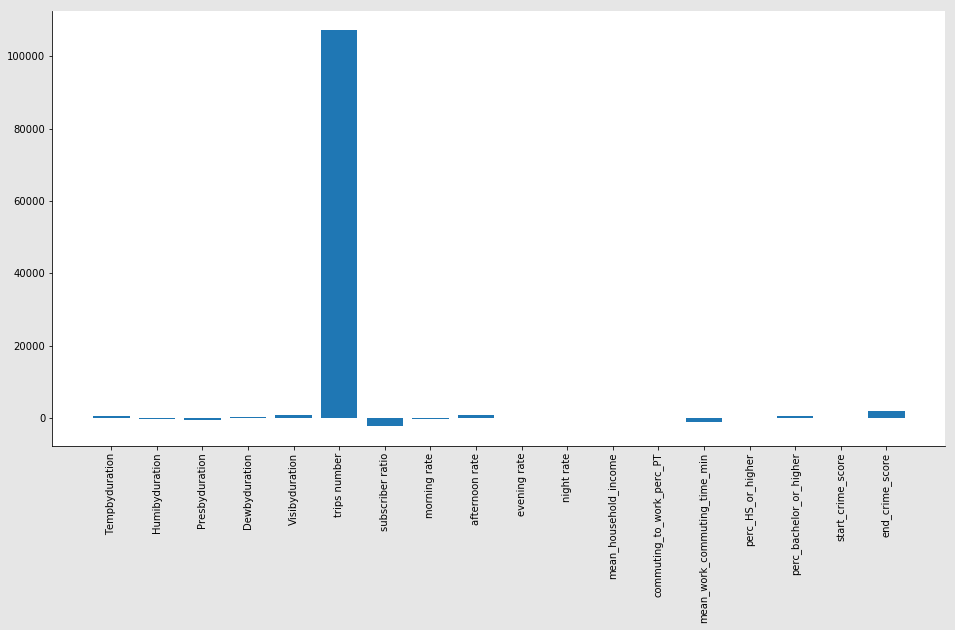

In [23]:
fig, ax = plt.subplots(figsize = [16,8], facecolor = [0.9,0.9,0.9])
x_pos = np.arange(len(train_feature.columns)-1)
 
plt.bar(x_pos, model.coef_[1:])
plt.xticks(x_pos, train_feature.columns[1:], rotation='vertical')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

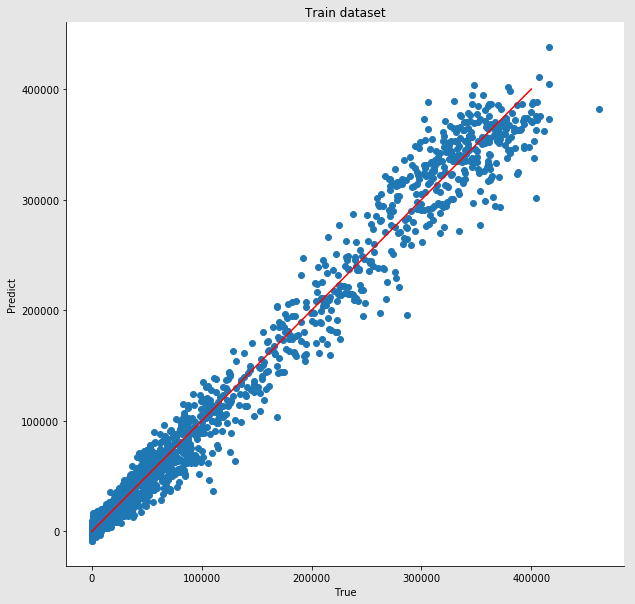

In [24]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_train_opti_oaf.true
y_axis = compare_predict_train_opti_oaf.predict
x_axis2 = range(400000)
y_axis2 = range(400000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

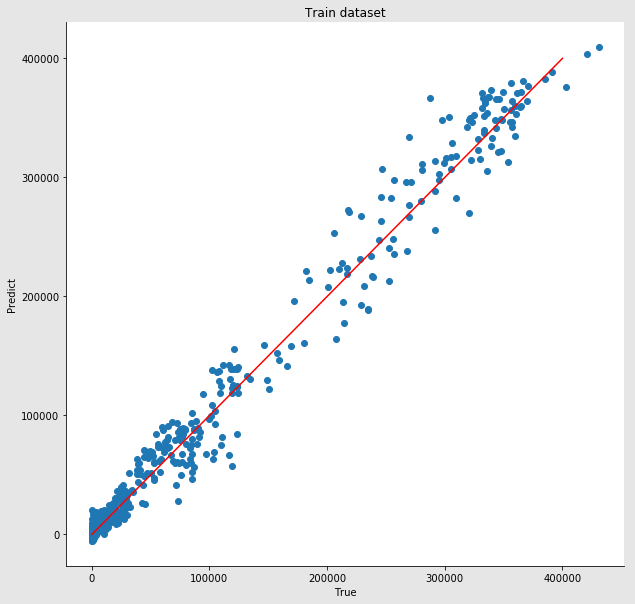

In [25]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_test_opti_oaf.true
y_axis = compare_predict_test_opti_oaf.predict
x_axis2 = range(400000)
y_axis2 = range(400000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
#plt.xticks(x_pos, train_feature.columns, rotation='vertical')
#plt.hist(interval_log, bins=30, alpha=0.75)
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
#plt.axis([0, 10000, 0, 1000000])
#ax.set_xlim([0, 20])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

*** Optimization - without trips count***

In [26]:
#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature_notrip, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature_notrip),test_target))
#grid.best_params_

So the best parameters using all features are:
{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [27]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_notrip, train_target)

NameError: name 'train_feature_notrip' is not defined

In [ ]:
rmse_opti_notc_train = compute_rmse(model.predict(train_feature_notrip),train_target)/np.mean(train_target)
rmse_opti_notc_test =compute_rmse(model.predict(test_feature_notrip),test_target)/np.mean(test_target)
row_name.append('original_withouttripcount')
rmse_ratio_train.append(rmse_opti_notc_train)
rmse_ratio_test.append(rmse_opti_notc_test)


In [ ]:
compare_predict_train_opti_notc = caculateratio(model, train_feature_notrip, train_target)
error_ratio_train.append(compare_predict_train_opti_notc.abs_precent.median())
compare_predict_test_opti_notc = caculateratio(model, test_feature_notrip, test_target)
error_ratio_test.append(compare_predict_test_opti_notc.abs_precent.median())

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor = [0.9,0.9,0.9])
x_pos = np.arange(len(train_feature_notrip.columns)-1)
 
plt.bar(x_pos, model.coef_[1:])
plt.xticks(x_pos, train_feature_notrip.columns[1:], rotation='vertical')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_train_opti_notc.true
y_axis = compare_predict_train_opti_notc.predict
x_axis2 = range(400000)
y_axis2 = range(400000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset_without trip counts')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_test_opti_notc.true
y_axis = compare_predict_test_opti_notc.predict
x_axis2 = range(400000)
y_axis2 = range(400000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Test dataset_without trip counts')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

### 3.1.2 Error Analysis

*** with all features***

In [29]:
def getimportantfeature(model, feature, number=5):
    # calculate the most X important features
    important_list = []
    number_list = list(range(-number, 0))
    temp = np.argpartition(np.abs(model.coef_), number_list)
    for i in number_list[::-1]:
        important_list.append(feature.columns.tolist()[temp[i]])
    return important_list

def getsimilarrow(dataset, index, feature_list, round_number=1):
    # get the similar samples
    sample = dataset.iloc[index]
    subset = dataset[dataset[feature_list[0]].round(round_number) == sample[feature_list[0]].round(round_number)]
    for feature in feature_list:
        subset = subset[subset[feature].round(round_number) == sample[feature].round(round_number)]
    return subset

def comparesimilar(subset_index, index, target):
    # get the value of the target and the mean value of the similar samples
    subset_value = pd.DataFrame(target).loc[subset_index]
    compare_value = subset_value.loc[index]
    subset_value = subset_value[subset_value.index !=index]
    print('outlier value:', compare_value)
    print('mean of similar observations:', subset_value.duration.mean())
    print('median of similar observations:', subset_value.duration.median())
    return compare_value, subset_value


In [30]:
model = Lasso(alpha=18, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature, train_target)

Lasso(alpha=18, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
important_list = getimportantfeature(model, train_feature, 1)
important_list

In [31]:
subset = getsimilarrow(train_feature, 1325, important_list, round_number=1)
subset.shape

NameError: name 'important_list' is not defined

In [ ]:
compare_value, subset_value = comparesimilar(subset.index, 1325, train_target)

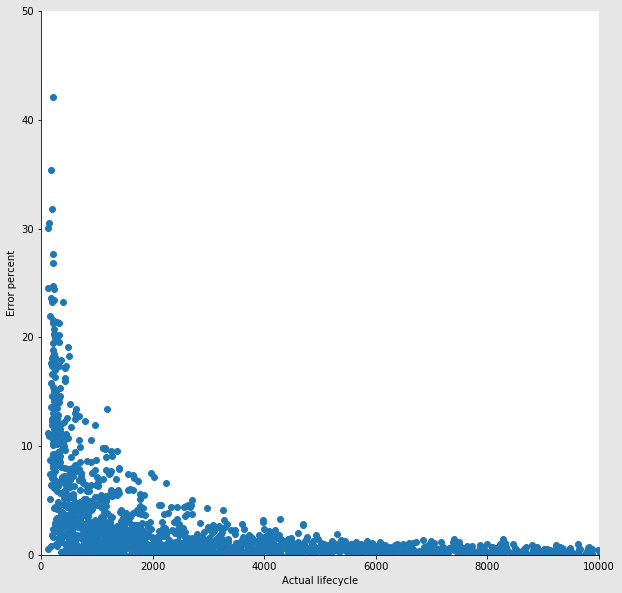

In [32]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])
x_axis = compare_predict_train_opti_oaf.true
y_axis = compare_predict_train_opti_oaf.abs_precent
plt.xlabel('Actual lifecycle')
plt.ylabel('Error percent')
plt.scatter(x_axis, y_axis)
plt.axis([0, 10000, 0, 50])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

In [33]:
# most big error precentage happen when actual lifecycle is less than 600 seconds
temp= compare_predict_train_opti_oaf[compare_predict_train_opti_oaf.abs_precent>10]
len(temp[temp.true<600])/temp.shape[0]

0.9137931034482759

In [34]:
# When lifecycle is less than 600 seconds, the error precentage also tends to be huge
temp = compare_predict_train_opti_oaf[compare_predict_train_opti_oaf.true<600]
temp.abs_precent.mean(), temp.abs_precent.median()

(9.45665004256168, 8.00042867963622)

### Thus we think these lifecycle < 600 are noise and decide to remove them from the original dataset

*** Trim Dataset***

In [35]:
trim_cycle = life_cycle[life_cycle.duration > 600]

In [36]:
# reset index
trim_cycle.reset_index(drop=True, inplace=True)

# shuffle and generate index for training/test
np.random.seed(seed=13579)
#train_idx = np.random.choice(range(len(life_cycle)), int(len(life_cycle) * .8), replace=False)
train_idx = np.random.choice(range(len(trim_cycle)), 2800, replace=False)
test_idx = list(set(range(len(trim_cycle))) - set(list(train_idx)))

# generate training/test
bdata_train = trim_cycle.loc[train_idx]
bdata_test = trim_cycle.loc[test_idx]
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

# remove unnecessary columns
train_feature_600 = bdata_train.drop(['duration', 'bike_group'], axis=1)
test_feature_600 = bdata_test.drop(['duration', 'bike_group'], axis=1)
train_target_600 = bdata_train['duration']
test_target_600 = bdata_test['duration']

In [ ]:
#train_feature_600.to_csv('Dataset/train_feature_600.csv')
#train_target_600.to_csv('Dataset/train_target_600.csv')
#test_feature_600.to_csv('Dataset/test_feature_600.csv')
#test_target_600.to_csv('Dataset/test_target_600.csv')

***With all features***

In [ ]:
# find the best parameters 
#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature_600, train_target_600)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature_600),test_target_600))
#grid.best_params_

So the best parameters using all features are:
{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [ ]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_600, train_target_600)

In [37]:
rmse_600af_train = compute_rmse(model.predict(train_feature_600),train_target_600)/np.mean(train_target_600)
rmse_600af_test = compute_rmse(model.predict(test_feature_600),test_target_600)/np.mean(test_target_600)
row_name.append('trimmed_allfeatures')
rmse_ratio_train.append(rmse_600af_train)
rmse_ratio_test.append(rmse_600af_test)

compare_predict_600af_train = caculateratio(model, train_feature_600, train_target_600)
error_ratio_train.append(compare_predict_600af_train.abs_precent.median())
compare_predict_600af_test = caculateratio(model, test_feature_600, test_target_600)
error_ratio_test.append(compare_predict_600af_test.abs_precent.median())

***Without Trip Count***

In [38]:
train_feature_600_new = train_feature_600.drop('trips number', axis=1)
test_feature_600_new = test_feature_600.drop('trips number', axis=1)

In [ ]:
# find the best parameters 
#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature_600_new, train_target_600)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature_600_new),test_target_600))
#grid.best_params_

So the best parameters using all features are:
{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [39]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_600_new, train_target_600)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
rmse_600notcaf_train = compute_rmse(model.predict(train_feature_600_new),train_target_600)/np.mean(train_target_600)
rmse_600notcaf_test = compute_rmse(model.predict(test_feature_600_new),test_target_600)/np.mean(test_target_600)
row_name.append('trimmed_withouttripcounts')
rmse_ratio_train.append(rmse_600notcaf_train)
rmse_ratio_test.append(rmse_600notcaf_test)

compare_predict_600notcaf_train = caculateratio(model, train_feature_600_new, train_target_600)
error_ratio_train.append(compare_predict_600notcaf_train.abs_precent.median())
compare_predict_600notcaf_test = caculateratio(model, test_feature_600_new, test_target_600)
error_ratio_test.append(compare_predict_600notcaf_test.abs_precent.median())

*** Compare results ***

In [41]:
result_compare = pd.DataFrame({'Rmse_percent_train': rmse_ratio_train,
                               'Rmse_percent_test': rmse_ratio_test,
                               'Error_percent_train': error_ratio_train,
                               'Error_percent_test': error_ratio_test},
                                index = row_name)

In [ ]:
result_compare.style.format("{:.2%}")

## 3.2 Decision Tree

In [51]:
def compute_rmse_ratio(predictions, yvalues):
    pre = np.asarray(predictions)
    y = np.asarray(yvalues)
    rmse = np.sqrt(np.sum((pre-y) ** 2) / float(len(y)))
    compute_rmse_ratio = rmse/np.mean(y)
    return compute_rmse_ratio
def caculateratio(clf, feature, target):
    predict_y = clf.predict(feature)
    compare_predict = pd.concat([target, pd.DataFrame(predict_y)], axis=1)
    compare_predict.columns = ['true', 'predict']
    compare_predict['error_ratio'] = (compare_predict.predict - compare_predict.true) / compare_predict.true
    compare_predict['abs_ratio'] = np.abs(compare_predict['error_ratio'])
    return compare_predict

In [65]:
# remove unnecessary columns
train_X = bdata_train.drop(['Unnamed: 0','duration', 'bike_group'], axis=1)
test_X = bdata_test.drop(['Unnamed: 0','duration', 'bike_group'], axis=1)
train_y = bdata_train['duration']
test_y = bdata_test['duration']

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features

# Decision Tree hyperparameters tuning with all features
param_grid_tree = {'max_depth': [1,5,10,15,20,25,30],
                   'min_samples_leaf': [1,2,3,4,5]}
                     
grid_tree = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree, cv=10)
grid_tree.fit(train_X, train_y)
best_tree = grid_tree.best_params_
print('Best parameters for tree using ALL features: {}'.format(best_tree))
print('Best score for tree on validation set using ALL features: {:.2f}'.format(grid_tree.best_score_))

Best parameters for tree using ALL features: {'max_depth': 5, 'min_samples_leaf': 5}
Best score for tree on validation set using ALL features: 0.98


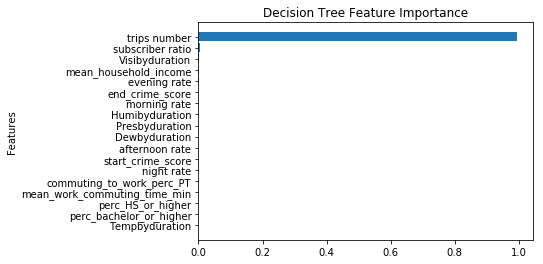

In [66]:
# Get feature importances using the optimal hyperparameters

features = train_X.columns.tolist()
clf_dt = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=5 , min_samples_leaf=5)
clf_dt.fit(train_X, train_y)
importances_dt = clf_dt.feature_importances_

idx_dt = np.argsort(importances_dt)
plt.title("Decision Tree Feature Importance")
plt.barh(range(len(idx_dt)), importances_dt[idx_dt])
plt.yticks(range(len(idx_dt)), [features[i] for i in idx_dt])
plt.ylabel("Features")
plt.show()

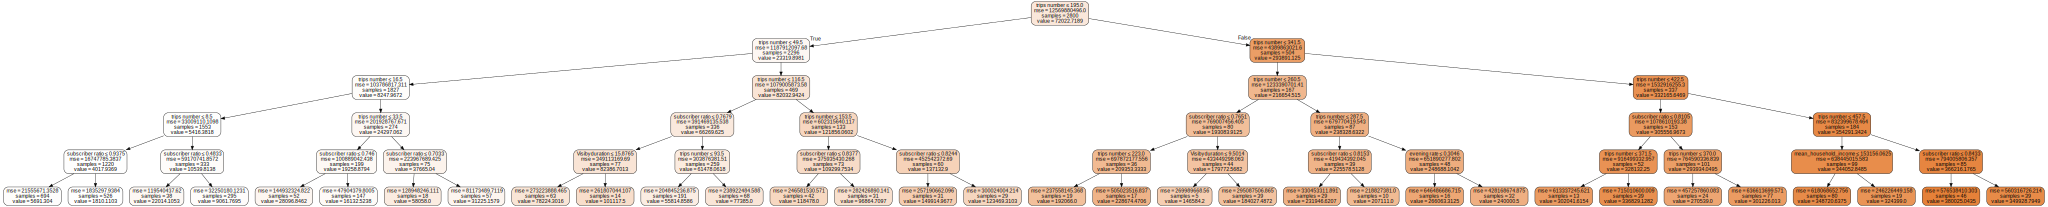

In [67]:
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(clf_dt, out_file=None, max_depth=5,
                         feature_names= features,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [68]:
import operator

# Get the most important features

map_importance_dt = dict(zip(features, importances_dt))
map_importance_dt = sorted(map_importance_dt.items(), key=operator.itemgetter(1), reverse=True)
map_importance_dt

[('trips number', 0.99482396599054967),
 ('subscriber ratio', 0.0043551283933097968),
 ('Visibyduration', 0.00035133782743743412),
 ('mean_household_income', 0.00026119470054277735),
 ('evening rate', 0.00020837308816040571),
 ('Tempbyduration', 0.0),
 ('Humibyduration', 0.0),
 ('Presbyduration', 0.0),
 ('Dewbyduration', 0.0),
 ('morning rate', 0.0),
 ('afternoon rate', 0.0),
 ('night rate', 0.0),
 ('commuting_to_work_perc_PT', 0.0),
 ('mean_work_commuting_time_min', 0.0),
 ('perc_HS_or_higher', 0.0),
 ('perc_bachelor_or_higher', 0.0),
 ('start_crime_score', 0.0),
 ('end_crime_score', 0.0)]

In [100]:
# Get the top 4 most important features with importance score > 0.00025
feature_4 = [item[0] for item in map_importance_dt[:4]]
feature_4

['trips number', 'subscriber ratio', 'Visibyduration', 'mean_household_income']

In [70]:
# Create new dataframes for train/test features using only the 4 most important features
train_X4 = train_X.loc[:, feature_4]
test_X4 = test_X.loc[:, feature_4]
train_X4.head(2)

,trips number,subscriber ratio,Visibyduration,mean_household_income
0,4,0.25,9.438355,203908.0
1,4,0.50,10.000000,137578.5


In [71]:
# Before moving on, we get the RMSE for train/test sets using ALL feature with optimal hyperparameters

# train RMSE
y_train_predict_dt = clf_dt.predict(train_X)
rmse_ratio_train_dt = compute_rmse_ratio(y_train_predict_dt, train_y)


# test RMSE
y_test_predict_dt = clf_dt.predict(test_X)
rmse_ratio_test_dt = compute_rmse_ratio(y_test_predict_dt, test_y)

print("Tree RMSE Percentage of training set using ALL features: {:.0%}".format(rmse_ratio_train_dt))
print("Tree RMSE Percentage of test set using ALL features: {:.0%}".format(rmse_ratio_test_dt))

# Error Ratio
err_ratio_train_dt = np.median(caculateratio(clf_dt, train_X, train_y).abs_ratio)
err_ratio_test_dt = np.median(caculateratio(clf_dt, test_X, test_y).abs_ratio)
print("Tree Error Percentage of training set using ALL features: {:.0%}".format(err_ratio_train_dt))
print("Tree Error Percentage of test set using ALL features: {:.0%}".format(err_ratio_test_dt))

Tree RMSE Percentage of training set using ALL features: 17%
Tree RMSE Percentage of test set using ALL features: 21%
Tree Error Percentage of training set using ALL features: 25%
Tree Error Percentage of test set using ALL features: 26%


In [72]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 4 most important features

param_grid_tree_4 = {'max_depth': [1,5,10,15,20,25,30],
                     'min_samples_leaf': [1,2,3,4,5]}
grid_tree_4 = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_4, cv=10)
grid_tree_4.fit(train_X4, train_y)
best_tree_4 = grid_tree_4.best_params_
print('Best parameters for tree using 4 features: {}'.format(best_tree_4))
print('Best score for tree on validation set using 4 features: {:.2f}'.format(grid_tree_4.best_score_))

Best parameters for tree using 4 features: {'max_depth': 10, 'min_samples_leaf': 5}
Best score for tree on validation set using 4 features: 0.99


In [73]:
# Run/Fit the model with optimal hyperparameters using only 7 most important features

clf_dt_4 = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=10 , min_samples_leaf=5)
clf_dt_4.fit(train_X4, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
           splitter='best')

In [74]:
# get the RMSE for train/test sets using 4 features with optimal hyperparameters

# train RMSE ratio with 4 features
y_train_predict_dt_4 = clf_dt_4.predict(train_X4)
rmse_ratio_train_dt_4 = compute_rmse_ratio(y_train_predict_dt_4, train_y)

# test RMSE ratio with 4 features
y_test_predict_dt_4 = clf_dt_4.predict(test_X4)
rmse_ratio_test_dt_4 = compute_rmse_ratio(y_test_predict_dt_4, test_y)
print("Tree RMSE Percentage of training set using 4 features: {:.0%}".format(rmse_ratio_train_dt_4))
print("Tree RMSE Percentage of test set using 4 features: {:.0%}".format(rmse_ratio_test_dt_4))

# Error Ratio
err_ratio_train_dt_4 = np.median(caculateratio(clf_dt_4, train_X4, train_y).abs_ratio)
err_ratio_test_dt_4 = np.median(caculateratio(clf_dt_4, test_X4, test_y).abs_ratio)
print("Tree Error Percentage of training set using 4 features: {:.0%}".format(err_ratio_train_dt_4))
print("Tree Error Percentage of test set using 4 features: {:.0%}".format(err_ratio_test_dt_4))

Tree RMSE Percentage of training set using 4 features: 12%
Tree RMSE Percentage of test set using 4 features: 21%
Tree Error Percentage of training set using 4 features: 15%
Tree Error Percentage of test set using 4 features: 22%


***Re-run Model after Removing trips number variable***

In [75]:
# Get the new dataframes for train/test set after removing "trips number" variable, considering it might not be independent
train_X_wt_tn = train_X.drop(["trips number"], axis=1)
test_X_wt_tn = test_X.drop(["trips number"], axis=1)
print(train_X_wt_tn.shape)
print(test_X_wt_tn.shape)

(2800, 17)
(658, 17)


In [84]:
# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features without "trips number"

# Decision Tree hyperparameters tuning with all features without "trips number"
param_grid_tree_wt_tn = {'max_depth': [1,5,10,15,20,25,30],
                           'min_samples_leaf': [1,2,3,4,5]}
grid_tree_wt_tn = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_wt_tn, cv=10)
grid_tree_wt_tn.fit(train_X_wt_tn, train_y)
best_tree_wt_tn = grid_tree_wt_tn.best_params_
print('Tree Best parameters using ALL features without "trips number": {}'.format(best_tree_wt_tn))
print('Tree Best score on validation set using ALL features without "trips number": {:.2f}'.format(grid_tree_wt_tn.best_score_))

Tree Best parameters using ALL features without "trips number": {'max_depth': 10, 'min_samples_leaf': 5}
Tree Best score on validation set using ALL features without "trips number": 0.89


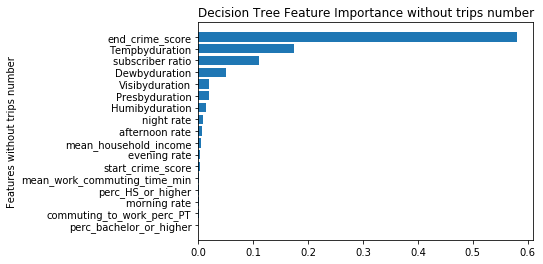

In [85]:
# Get feature importances using the optimal hyperparameters (without trips numbers)

features_wt_tn = train_X_wt_tn.columns.tolist()
clf_dt_wt_tn = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=10 , min_samples_leaf=5)
clf_dt_wt_tn.fit(train_X_wt_tn, train_y)
importances_dt_wt_tn = clf_dt_wt_tn.feature_importances_

idx_dt_wt_tn = np.argsort(importances_dt_wt_tn)
plt.title("Decision Tree Feature Importance without trips number")
plt.barh(range(len(idx_dt_wt_tn)), importances_dt_wt_tn[idx_dt_wt_tn])
plt.yticks(range(len(idx_dt_wt_tn)), [features_wt_tn[i] for i in idx_dt_wt_tn])
plt.ylabel("Features without trips number")
plt.show()

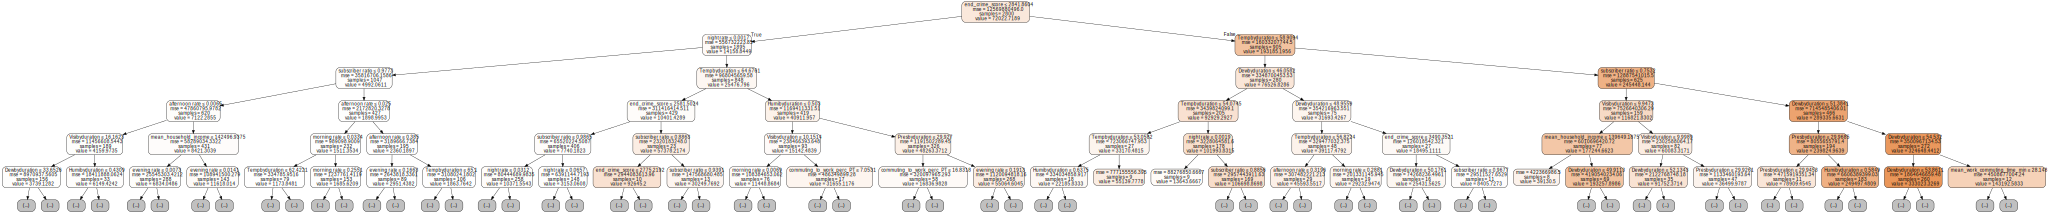

In [86]:
dot_data2 = tree.export_graphviz(clf_dt_wt_tn, out_file=None, max_depth=5,
                         feature_names= features_wt_tn,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data2)  
graph

In [87]:
# Get the most important features without trips number

map_importance_dt_wt_tn = dict(zip(features_wt_tn, importances_dt_wt_tn))
map_importance_dt_wt_tn = sorted(map_importance_dt_wt_tn.items(), key=operator.itemgetter(1), reverse=True)
map_importance_dt_wt_tn

[('end_crime_score', 0.58116430611700731),
 ('Tempbyduration', 0.17483604163882313),
 ('subscriber ratio', 0.10994658809571205),
 ('Dewbyduration', 0.049894946365955858),
 ('Visibyduration', 0.0201009816625148),
 ('Presbyduration', 0.019730401039706399),
 ('Humibyduration', 0.012866764813002196),
 ('night rate', 0.0088872994750900259),
 ('afternoon rate', 0.0072718922357940495),
 ('mean_household_income', 0.0055573723545478196),
 ('evening rate', 0.0028828238878214271),
 ('start_crime_score', 0.0026033881913969919),
 ('mean_work_commuting_time_min', 0.0017170706073473107),
 ('perc_HS_or_higher', 0.0011849492005775617),
 ('morning rate', 0.0010368174206033249),
 ('commuting_to_work_perc_PT', 0.00031756734061342672),
 ('perc_bachelor_or_higher', 7.8955348629314473e-07)]

In [82]:
# Get the most important features without trips number

map_importance_dt_wt_tn = dict(zip(features_wt_tn, importances_dt_wt_tn))
map_importance_dt_wt_tn = sorted(map_importance_dt_wt_tn.items(), key=operator.itemgetter(1), reverse=True)
map_importance_dt_wt_tn

[('end_crime_score', 0.58116430611700731),
 ('Tempbyduration', 0.17483604163882313),
 ('subscriber ratio', 0.10994658809571205),
 ('Dewbyduration', 0.049894946365955858),
 ('Visibyduration', 0.0201009816625148),
 ('Presbyduration', 0.019730401039706399),
 ('Humibyduration', 0.012866764813002196),
 ('night rate', 0.0088872994750900259),
 ('afternoon rate', 0.0072718922357940495),
 ('mean_household_income', 0.0055573723545478196),
 ('evening rate', 0.0028828238878214271),
 ('start_crime_score', 0.0026033881913969919),
 ('mean_work_commuting_time_min', 0.0017170706073473107),
 ('perc_HS_or_higher', 0.0011849492005775617),
 ('morning rate', 0.0010368174206033249),
 ('commuting_to_work_perc_PT', 0.00031756734061342672),
 ('perc_bachelor_or_higher', 7.8955348629314473e-07)]

In [88]:
# Get the most important 4 features with an importance score larger than 0.04
feature_4_wt_tn = [item[0] for item in map_importance_dt_wt_tn[:4]]
feature_4_wt_tn

['end_crime_score', 'Tempbyduration', 'subscriber ratio', 'Dewbyduration']

In [89]:
# Create new dataframes for train/test features using only the most 4 important features

train_4_wt_tn = train_X_wt_tn.loc[:, feature_4_wt_tn]
test_4_wt_tn = test_X_wt_tn.loc[:, feature_4_wt_tn]
train_4_wt_tn.head(2)

,end_crime_score,Tempbyduration,subscriber ratio,Dewbyduration
0,465.611111,60.754700,0.25,49.017859
1,55.333333,79.236954,0.50,54.246069


In [90]:
# Before moving on, we get the RMSE for train/test sets using ALL feature (without trips number) with optimal hyperparameters

# train RMSE
y_train_predict_dt_wt_tn = clf_dt_wt_tn.predict(train_X_wt_tn)
rmse_ratio_train_dt_wt_tn = compute_rmse_ratio(y_train_predict_dt_wt_tn, train_y)

# test RMSE
y_test_predict_dt_wt_tn = clf_dt_wt_tn.predict(test_X_wt_tn)
rmse_ratio_test_dt_wt_tn = compute_rmse_ratio(y_test_predict_dt_wt_tn, test_y)

print("Tree RMSE Percentage of training set using ALL features without trips number: {:.0%}".format(rmse_ratio_train_dt_wt_tn))
print("Tree RMSE Percentage of test set using ALL features without trips number: {:.0%}".format(rmse_ratio_test_dt_wt_tn))

# Error Ratio
err_ratio_train_dt_wt_tn = np.median(caculateratio(clf_dt_wt_tn, train_X_wt_tn, train_y).abs_ratio)
err_ratio_test_dt_wt_tn = np.median(caculateratio(clf_dt_wt_tn, test_X_wt_tn, test_y).abs_ratio)
print("Tree Error Percentage of training set using ALL features without trips number: {:.0%}".format(err_ratio_train_dt_wt_tn))
print("Tree Error Percentage of test set using ALL features without trips number: {:.0%}".format(err_ratio_test_dt_wt_tn))

Tree RMSE Percentage of training set using ALL features without trips number: 29%
Tree RMSE Percentage of test set using ALL features without trips number: 58%
Tree Error Percentage of training set using ALL features without trips number: 22%
Tree Error Percentage of test set using ALL features without trips number: 36%


In [91]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 4 most important features

param_grid_tree_4_wt_tn = {'max_depth': [1,5,10,15,20,25,30],
                     'min_samples_leaf': [1,2,3,4,5]}                  
grid_tree_4_wt_tn = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_4_wt_tn, cv=10)
grid_tree_4_wt_tn.fit(train_4_wt_tn, train_y)
best_tree_4_wt_tn = grid_tree_4_wt_tn.best_params_
print('Tree Best parameters using 4 features without trips number: {}'.format(best_tree_4_wt_tn))
print('Tree Best score on validation set using 4 features without trips number: {:.2f}'.format(grid_tree_4_wt_tn.best_score_))

Tree Best parameters using 4 features without trips number: {'max_depth': 10, 'min_samples_leaf': 5}
Tree Best score on validation set using 4 features without trips number: 0.88


In [92]:
# Run/Fit the model with optimal hyperparameters using only 4 most important features

clf_dt_4_wt_tn = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=10 , min_samples_leaf=5)
clf_dt_4_wt_tn.fit(train_4_wt_tn, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
           splitter='best')

In [93]:
# get the RMSE for train/test sets using 4 features with optimal hyperparameters (without trips number)

# train RMSE with 4 features
y_train_predict_dt_4_wt_tn = clf_dt_4_wt_tn.predict(train_4_wt_tn)
rmse_ratio_train_dt_4_wt_tn = compute_rmse_ratio(y_train_predict_dt_4_wt_tn, train_y)


# test RMSE with 4 features
y_test_predict_dt_4_wt_tn = clf_dt_4_wt_tn.predict(test_4_wt_tn)
rmse_ratio_test_dt_4_wt_tn = compute_rmse_ratio(y_test_predict_dt_4_wt_tn, test_y)
print("Tree RMSE Percentage of training set using 4 features without trips number: {:.0%}".format(rmse_ratio_train_dt_4_wt_tn))
print("Tree RMSE Percentage of test set using 4 features without trips number: {:.0%}".format(rmse_ratio_test_dt_4_wt_tn))


# Error Ratio
err_ratio_train_dt_4_wt_tn = np.median(caculateratio(clf_dt_4_wt_tn, train_4_wt_tn, train_y).abs_ratio)
err_ratio_test_dt_4_wt_tn = np.median(caculateratio(clf_dt_4_wt_tn, test_4_wt_tn, test_y).abs_ratio)
print("Tree Error Percentage of training set using 4 features without trips number: {:.0%}".format(err_ratio_train_dt_4_wt_tn))
print("Tree Error Percentage of test set using 4 features without trips number: {:.0%}".format(err_ratio_test_dt_4_wt_tn))

Tree RMSE Percentage of training set using 4 features without trips number: 35%
Tree RMSE Percentage of test set using 4 features without trips number: 59%
Tree Error Percentage of training set using 4 features without trips number: 28%
Tree Error Percentage of test set using 4 features without trips number: 40%


In [96]:
row_idx = ['Train RMSE perc', 'Test RMSE perc', 'Train err perc', 'Test err perc']
all_features_dt = [rmse_ratio_train_dt, rmse_ratio_test_dt, err_ratio_train_dt, err_ratio_test_dt]
important_features_dt = [rmse_ratio_train_dt_4, rmse_ratio_test_dt_4, err_ratio_train_dt_4, err_ratio_test_dt_4]
all_feature_wt_tn_dt = [rmse_ratio_train_dt_wt_tn, rmse_ratio_test_dt_wt_tn, err_ratio_train_dt_wt_tn, err_ratio_test_dt_wt_tn]
important_features_wt_tn_dt = [rmse_ratio_train_dt_4_wt_tn, rmse_ratio_test_dt_4_wt_tn, err_ratio_train_dt_4_wt_tn, err_ratio_test_dt_4_wt_tn]
tree_metrics_compare = pd.DataFrame({'Metrics': row_idx,
                             'All Features': all_features_dt, 
                             'Top 4 Features': important_features_dt,
                             'All Features w/o tn': all_feature_wt_tn_dt,
                             'Top 4 Features w/o tn': important_features_wt_tn_dt
                              })
cols = ['All Features', 'Top 4 Features', 'All Features w/o tn', 'Top 4 Features w/o tn', 'Metrics']
tree_metrics_compare = tree_metrics_compare[cols]
tree_metrics_compare = tree_metrics_compare.set_index(['Metrics'])
tree_metrics_compare.iloc[0] = (tree_metrics_compare.iloc[0].apply('{:.0%}'.format))
tree_metrics_compare.iloc[1] = (tree_metrics_compare.iloc[1].apply('{:.0%}'.format))
tree_metrics_compare.iloc[2] = (tree_metrics_compare.iloc[2].apply('{:.0%}'.format))
tree_metrics_compare.iloc[3] = (tree_metrics_compare.iloc[3].apply('{:.0%}'.format))
tree_metrics_compare.style.set_properties(**{'text-align': 'right'})

,All Features,Top 4 Features,All Features w/o tn,Top 4 Features w/o tn
Metrics,,,,
Train RMSE perc,17%,12%,29%,35%
Test RMSE perc,21%,21%,58%,59%
Train err perc,25%,15%,22%,28%
Test err perc,26%,22%,36%,40%


## 3.3 Random Forest

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [99]:
# # First, get the optimal hyperparameters through GridSearchCV tuning using ALL features

# # Random Forest hyperparameters tuning with all features
# param_grid_forest = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest, cv=10)
# grid_forest.fit(train_X, train_y)
# best_RandomForest = grid_forest.best_params_
# print('Best parameters using ALL features: {}'.format(best_RandomForest))
# print('Best score on validation set using ALL features: {:.2f}'.format(grid_forest.best_score_))

Best parameters using ALL features: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Best score on validation set using ALL features: 0.99


Best parameters using ALL features: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}  
Best score on validation set using ALL features: 0.99

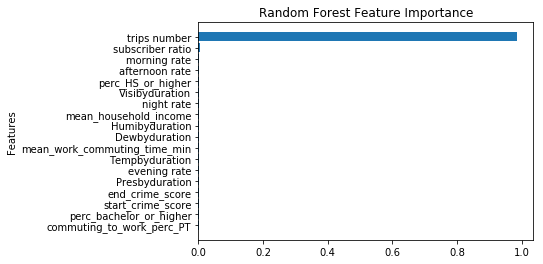

In [102]:
# Get feature importances using the optimal hyperparameters

features = train_X.columns.tolist()
clf_RF = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=10 , min_samples_leaf=2)
clf_RF.fit(train_X, train_y)
importances_RF = clf_RF.feature_importances_

idx = np.argsort(importances_RF)
plt.title("Random Forest Feature Importance")
plt.barh(range(len(idx)), importances_RF[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Features")
plt.show()

In [103]:
import operator

# Get the most important features

map_importance = dict(zip(features, importances_RF))
map_importance = sorted(map_importance.items(), key=operator.itemgetter(1), reverse=True)
map_importance

[('trips number', 0.98598213811755586),
 ('subscriber ratio', 0.0051851090560273618),
 ('morning rate', 0.00096711275279486226),
 ('afternoon rate', 0.00096295124760273256),
 ('perc_HS_or_higher', 0.00083001518924518064),
 ('Visibyduration', 0.00068820401596773352),
 ('night rate', 0.00062870438899017211),
 ('mean_household_income', 0.00060181344857370474),
 ('Humibyduration', 0.00059016212758652086),
 ('Dewbyduration', 0.00050128745522220802),
 ('mean_work_commuting_time_min', 0.00047744291064302465),
 ('Tempbyduration', 0.00046263350607387871),
 ('evening rate', 0.00046115044479053818),
 ('Presbyduration', 0.00043355948052812968),
 ('end_crime_score', 0.00034479883610498516),
 ('start_crime_score', 0.00032654571912257255),
 ('perc_bachelor_or_higher', 0.00030283304875696073),
 ('commuting_to_work_perc_PT', 0.00025353825441359993)]

In [104]:
# Get the top 7 most importance features with importance score > 0.00062
feature_7 = [item[0] for item in map_importance[:7]]
feature_7

['trips number',
 'subscriber ratio',
 'morning rate',
 'afternoon rate',
 'perc_HS_or_higher',
 'Visibyduration',
 'night rate']

In [105]:
# Create new dataframes for train/test features using only the most important features
train_X7 = train_X.loc[:, feature_7]
test_X7 = test_X.loc[:, feature_7]
train_X7.head(2)

,trips number,subscriber ratio,morning rate,afternoon rate,perc_HS_or_higher,Visibyduration,night rate
0,4,0.25,0.061322,0.779468,0.973333,9.438355,0.0
1,4,0.50,0.000000,0.838922,0.935000,10.000000,0.0


In [106]:
# Before moving on, we get the RMSE for train/test sets using ALL feature with optimal hyperparameters

# train RMSE
y_train_predict = clf_RF.predict(train_X)
rmse_ratio_train = compute_rmse_ratio(y_train_predict, train_y)


# test RMSE
y_test_predict = clf_RF.predict(test_X)
rmse_ratio_test = compute_rmse_ratio(y_test_predict, test_y)
print("Random Forest RMSE Percentage of training set using ALL features: {:.0%}".format(rmse_ratio_train))
print("Random Forest RMSE Percentage of test set using ALL features: {:.0%}".format(rmse_ratio_test))

# Error Ratio
err_ratio_train = np.median(caculateratio(clf_RF, train_X, train_y).abs_ratio)
err_ratio_test = np.median(caculateratio(clf_RF, test_X, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using ALL features: {:.0%}".format(err_ratio_train))
print("Random Forest Error Percentage of test set using ALL features: {:.0%}".format(err_ratio_test))

Random Forest RMSE Percentage of training set using ALL features: 8%
Random Forest RMSE Percentage of test set using ALL features: 18%
Random Forest Error Percentage of training set using ALL features: 12%
Random Forest Error Percentage of test set using ALL features: 20%


In [ ]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 7 most important features

# param_grid_forest_7 = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_7 = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_7, cv=10)
# grid_forest_7.fit(train_X7, train_y)
# best_RandomForest_7 = grid_forest_7.best_params_
# print('Best parameters using 7 features: {}'.format(best_RandomForest_7))
# print('Best score on validation set using 7 features: {:.2f}'.format(grid_forest_7.best_score_))

Best parameters using 7 features: {'max_depth': 25, 'min_samples_leaf': 4, 'n_estimators': 100}  
Best score on validation set using 7 features: 0.99

In [107]:
# Run/Fit the model with optimal hyperparameters using only 7 most important features

clf_RF_7 = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=25 , min_samples_leaf=4)
clf_RF_7.fit(train_X7, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=1234,
           verbose=0, warm_start=False)

In [108]:
# get the RMSE ratio for train/test sets using 7 features with optimal hyperparameters

# train RMSE ratio with 7 features
y_train_predict_7 = clf_RF_7.predict(train_X7)
rmse_ratio_train_7 = compute_rmse_ratio(y_train_predict_7, train_y)

# test RMSE ratio with 7 features
y_test_predict_7 = clf_RF_7.predict(test_X7)
rmse_ratio_test_7 = compute_rmse_ratio(y_test_predict_7, test_y)
print("Random Forest RMSE Percentage of training set using 7 features: {:.0%}".format(rmse_ratio_train_7))
print("Random Forest RMSE Percentage of test set using 7 features: {:.0%}".format(rmse_ratio_test_7))

# Error Ratio
err_ratio_train_7 = np.median(caculateratio(clf_RF_7, train_X7, train_y).abs_ratio)
err_ratio_test_7 = np.median(caculateratio(clf_RF_7, test_X7, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using 7 features: {:.0%}".format(err_ratio_train_7))
print("Random Forest Error Percentage of test set using 7 features: {:.0%}".format(err_ratio_test_7))

Random Forest RMSE Percentage of training set using 7 features: 10%
Random Forest RMSE Percentage of test set using 7 features: 17%
Random Forest Error Percentage of training set using 7 features: 11%
Random Forest Error Percentage of test set using 7 features: 19%


***Re-run Model after Removing trips number variable***

In [109]:
# Get the new dataframes for train/test set after removing "trips number" variable, considering it might not be independent
train_X_wt_tn = train_X.drop(["trips number"], axis=1)
test_X_wt_tn = test_X.drop(["trips number"], axis=1)
print(train_X_wt_tn.shape)
print(test_X_wt_tn.shape)

(2800, 17)
(658, 17)


In [ ]:
# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features without "trips number"

# Random Forest hyperparameters tuning with all features without "trips number"
# param_grid_forest_wt_tn = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_wt_tn = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_wt_tn, cv=10)
# grid_forest_wt_tn.fit(train_X_wt_tn, train_y)
# best_RandomForest_wt_tn = grid_forest_wt_tn.best_params_
# print('Best parameters using ALL features without "trips number": {}'.format(best_RandomForest_wt_tn))
# print('Best score on validation set using ALL features without "trips number": {:.2f}'.format(grid_forest_wt_tn.best_score_))

Best parameters using ALL features without "trips number": {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 100}  
Best score on validation set using ALL features without "trips number": 0.93

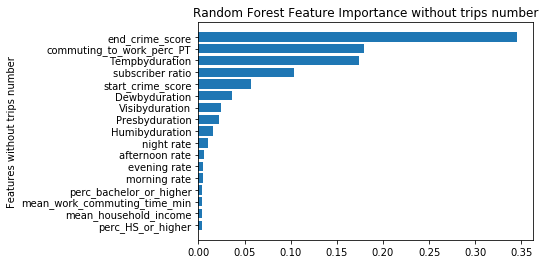

In [110]:
# Get feature importances using the optimal hyperparameters (without trips numbers)

features_wt_tn = train_X_wt_tn.columns.tolist()
clf_RF_wt_tn = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=25 , min_samples_leaf=1 )
clf_RF_wt_tn.fit(train_X_wt_tn, train_y)
importances_RF_wt_tn = clf_RF_wt_tn.feature_importances_

idx_wt_tn = np.argsort(importances_RF_wt_tn)
plt.title("Random Forest Feature Importance without trips number")
plt.barh(range(len(idx_wt_tn)), importances_RF_wt_tn[idx_wt_tn])
plt.yticks(range(len(idx_wt_tn)), [features_wt_tn[i] for i in idx_wt_tn])
plt.ylabel("Features without trips number")
plt.show()

In [111]:
# Get the most important features without trips number

map_importance_wt_tn = dict(zip(features_wt_tn, importances_RF_wt_tn))
map_importance_wt_tn = sorted(map_importance_wt_tn.items(), key=operator.itemgetter(1), reverse=True)
map_importance_wt_tn

[('end_crime_score', 0.34546479786811096),
 ('commuting_to_work_perc_PT', 0.17919543938400814),
 ('Tempbyduration', 0.1744255623548624),
 ('subscriber ratio', 0.10339613350557374),
 ('start_crime_score', 0.057333667775756512),
 ('Dewbyduration', 0.036296167407172113),
 ('Visibyduration', 0.02431324178241244),
 ('Presbyduration', 0.022266163540776169),
 ('Humibyduration', 0.015507327242794505),
 ('night rate', 0.010884226775602478),
 ('afternoon rate', 0.0056025213822556664),
 ('evening rate', 0.0053890908339337398),
 ('morning rate', 0.0046730407208463286),
 ('perc_bachelor_or_higher', 0.004140662318470871),
 ('mean_work_commuting_time_min', 0.0039073783537338308),
 ('mean_household_income', 0.0038798954933360625),
 ('perc_HS_or_higher', 0.003324683260354172)]

In [112]:
# Get the most important 6 features with an importance score larger than 0.03
feature_6 = [item[0] for item in map_importance_wt_tn[:6]]
feature_6

['end_crime_score',
 'commuting_to_work_perc_PT',
 'Tempbyduration',
 'subscriber ratio',
 'start_crime_score',
 'Dewbyduration']

In [113]:
# Create new dataframes for train/test features using only the most 8 important features

train_X6 = train_X_wt_tn.loc[:, feature_6]
test_X6 = test_X_wt_tn.loc[:, feature_6]
train_X6.head(2)

,end_crime_score,commuting_to_work_perc_PT,Tempbyduration,subscriber ratio,start_crime_score,Dewbyduration
0,465.611111,6.3,60.754700,0.25,363.833333,49.017859
1,55.333333,5.8,79.236954,0.50,65.166667,54.246069


In [114]:
# Before moving on, we get the RMSE ratio for train/test sets using ALL feature (without trips number) with optimal hyperparameters

# train RMSE ratio
y_train_predict_wt_tn = clf_RF_wt_tn.predict(train_X_wt_tn)
rmse_ratio_train_wt_tn = compute_rmse_ratio(y_train_predict_wt_tn, train_y)

# test RMSE ratio
y_test_predict_wt_tn = clf_RF_wt_tn.predict(test_X_wt_tn)
rmse_ratio_test_wt_tn = compute_rmse_ratio(y_test_predict_wt_tn, test_y)
print("Random Forest RMSE Percentage of training set using ALL features without trips number: {:.0%}".format(rmse_ratio_train_wt_tn))
print("Random Forest RMSE Percentage of test set using ALL features without trips number: {:.0%}".format(rmse_ratio_test_wt_tn))

# Error Ratio
err_ratio_train_wt_tn = np.median(caculateratio(clf_RF_wt_tn, train_X_wt_tn, train_y).abs_ratio)
err_ratio_test_wt_tn = np.median(caculateratio(clf_RF_wt_tn, test_X_wt_tn, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using ALL features without trips number: {:.0%}".format(err_ratio_train_wt_tn))
print("Random Forest Error Percentage of test set using ALL features without trips number: {:.0%}".format(err_ratio_test_wt_tn))

Random Forest RMSE Percentage of training set using ALL features without trips number: 15%
Random Forest RMSE Percentage of test set using ALL features without trips number: 47%
Random Forest Error Percentage of training set using ALL features without trips number: 12%
Random Forest Error Percentage of test set using ALL features without trips number: 32%


In [ ]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 8 most important features

# param_grid_forest_6 = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_6 = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_6, cv=10)
# grid_forest_6.fit(train_X6, train_y)
# best_RandomForest_6 = grid_forest_6.best_params_
# print('Random Forest Best parameters using 6 features without trips number: {}'.format(best_RandomForest_6))
# print('Random Forest Best score on validation set using 6 features without trips number: {:.2f}'.format(grid_forest_6.best_score_))

Random Forest Best parameters using 6 features without trips number: {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}  
Random Forest Best score on validation set using 6 features without trips number: 0.91

In [115]:
# Run/Fit the model with optimal hyperparameters using only 6 most important features

clf_RF_6 = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=15 , min_samples_leaf=3)
clf_RF_6.fit(train_X6, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=1234,
           verbose=0, warm_start=False)

In [116]:
# get the RMSE ratio for train/test sets using 6 features with optimal hyperparameters (without trips number)

# train RMSE ratito with 6 features
y_train_predict_6 = clf_RF_6.predict(train_X6)
rmse_ratio_train_6 = compute_rmse_ratio(y_train_predict_6, train_y)

# test RMSE ratio with 6 features
y_test_predict_6 = clf_RF_6.predict(test_X6)
rmse_ratio_test_6 = compute_rmse_ratio(y_test_predict_6, test_y)
print("Random Forest RMSE Percentage of training set using 6 features without trips number: {:.0%}".format(rmse_ratio_train_6))
print("Random Forest RMSE Percentage of test set using 6 features without trips number: {:.0%}".format(rmse_ratio_test_6))

# Error Ratio
err_ratio_train_6 = np.median(caculateratio(clf_RF_6, train_X6, train_y).abs_ratio)
err_ratio_test_6 = np.median(caculateratio(clf_RF_6, test_X6, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using 6 features without trips number: {:.0%}".format(err_ratio_train_6))
print("Random Forest Error Percentage of test set using 6 features without trips number: {:.0%}".format(err_ratio_test_6))

Random Forest RMSE Percentage of training set using 6 features without trips number: 25%
Random Forest RMSE Percentage of test set using 6 features without trips number: 52%
Random Forest Error Percentage of training set using 6 features without trips number: 22%
Random Forest Error Percentage of test set using 6 features without trips number: 36%


In [117]:
row_idx = ['Train RMSE perc', 'Test RMSE perc', 'Train err perc', 'Test err perc']
all_features_RF = [rmse_ratio_train, rmse_ratio_test, err_ratio_train, err_ratio_test]
important_features_RF = [rmse_ratio_train_7, rmse_ratio_test_7, err_ratio_train_7, err_ratio_test_7]
all_feature_wt_tn_RF = [rmse_ratio_train_wt_tn, rmse_ratio_test_wt_tn, err_ratio_train_wt_tn, err_ratio_test_wt_tn]
important_features_wt_tn_RF = [rmse_ratio_train_6, rmse_ratio_test_6, err_ratio_train_6, err_ratio_test_6]
forest_metrics_compare = pd.DataFrame({'Metrics': row_idx,
                             'All Features': all_features_RF, 
                             'Top 7 Features': important_features_RF,
                             'All Features w/o tn': all_feature_wt_tn_RF,
                             'Top 6 Features w/o tn': important_features_wt_tn_RF
                              })
cols = ['All Features', 'Top 7 Features', 'All Features w/o tn', 'Top 6 Features w/o tn', 'Metrics']
forest_metrics_compare = forest_metrics_compare[cols]
forest_metrics_compare = forest_metrics_compare.set_index(['Metrics'])
forest_metrics_compare.iloc[0] = (forest_metrics_compare.iloc[0].apply('{:.0%}'.format))
forest_metrics_compare.iloc[1] = (forest_metrics_compare.iloc[1].apply('{:.0%}'.format))
forest_metrics_compare.iloc[2] = (forest_metrics_compare.iloc[2].apply('{:.0%}'.format))
forest_metrics_compare.iloc[3] = (forest_metrics_compare.iloc[3].apply('{:.0%}'.format))
forest_metrics_compare.style.set_properties(**{'text-align': 'right'})

,All Features,Top 7 Features,All Features w/o tn,Top 6 Features w/o tn
Metrics,,,,
Train RMSE perc,8%,10%,15%,25%
Test RMSE perc,18%,17%,47%,52%
Train err perc,12%,11%,12%,22%
Test err perc,20%,19%,32%,36%


# 4 Conclusion

From our models, we found that the most important features for predicting this lifetime is trip count, mean crime score of the end station, temperature by duration, and subscriber ratio.

From the features that we explored, there weren’t that many with linear relationships. Perhaps this is why the random forest performed better than linear regression.

Among the three models we trained, the RF provided the best performance with a test error percentage of 20%. This means that for our average lifecycle of 18 hours, our prediction for when the bike needs maintenance will lay within 3.6 hours of the true value. This isn’t perfect, but it is still a reasonable timeframe for the bike sharing companies to check-up on the bike. 